Reference: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [52]:
import pandas as pd
from pandas import DataFrame
from pandas.errors import InvalidIndexError
import os
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
from tensorflow.python.keras import Input, Model
from tensorflow.python.keras.layers import Lambda, Dense
import keras.backend as K
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm, datasets
import numpy as np
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from pandas import DataFrame
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
import tensorflow_hub as hub
from pandas import DataFrame
from pandas.errors import InvalidIndexError
import os
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
import seaborn as sns
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
def stemming_and_lemmatization(sentence):
    stemmer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    newSentence = re.sub(r'\W', ' ', sentence)
    newSentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', newSentence)
    newSentence = re.sub(r'\^[a-zA-Z]\s+', ' ', newSentence)
    newSentence = re.sub(r'\s+', ' ', newSentence, flags=re.I)
    newSentence = newSentence.lower()
    newSentence = newSentence.split()
    newSentence = [w for w in newSentence if not w in stop_words]
    newSentence = [stemmer.lemmatize(word) for word in newSentence]
    newSentence = ' '.join(newSentence)
    return newSentence

def isNaN(string):
    return string != string

def create_vectors_dataframe(df):
    model = KeyedVectors.load_word2vec_format('/home/kapil/SJSU-Acad/MastersProject/codebase/data/GoogleNews-vectors-negative300.bin', binary=True)
    for index, row in df.iterrows():
        if not isNaN(df['title'][index]):
            df['title'] = model[df['title']]
        if not isNaN(df['abstractText'][index]):
            df['abstractText'] = model[df['abstractText']]
        if not isNaN(df[' Introduction'][index]):
            df[' Introduction'] = model[df[' Introduction']]
        if not isNaN(df[' Conclusion'][index]):
            df[' Conclusion'] = model[df[' Conclusion']]
    return df

def preprocess_reviews_dataframe(df):
    for index, row in df.iterrows():
        print(index)
        row['abstractText'] = stemming_and_lemmatization(str(row['abstractText']))
        row['title'] = stemming_and_lemmatization(str(row['title']))
    return df

def preprocess_dataframe(df):
    for index, row in df.iterrows():
        print(index)
        row['abstractText'] = stemming_and_lemmatization(str(row['abstractText']))
        row['title'] = stemming_and_lemmatization(str(row['title']))
        row[' Introduction'] = stemming_and_lemmatization(str(row[' Introduction']))
        row[' Related Work'] = stemming_and_lemmatization(str(row[' Related Work']))
        row[' Conclusion'] = stemming_and_lemmatization(str(row[' Conclusion']))
        row[' Experiments'] = stemming_and_lemmatization(str(row[' Experiments']))
        row[' Results'] = stemming_and_lemmatization(str(row[' Results']))
        row[' Discussion'] = stemming_and_lemmatization(str(row[' Discussion']))
    return df

def tokenize_dataframe(df):
    for index, row in df.iterrows():
        df['abstractText'][index] = word_tokenize(str(df['abstractText'][index]))
        df['title'][index] = word_tokenize(df['title'][index])
        df[' Introduction'][index] = word_tokenize(df[' Introduction'][index])
        df[' Conclusion'][index] = word_tokenize(df[' Conclusion'][index])
        df[' Experiments'][index] = word_tokenize(df[' Experiments'][index])
        df[' Related Work'][index] = word_tokenize(df[' Related Work'][index])
        df[' Discussion'][index] = word_tokenize(df[' Discussion'][index])
        df[' Results'][index] = word_tokenize(df[' Results'][index])

    return df

def doc_to_vec(df):
    for column in df:
        if column == 'abstractText' or column == 'title' or column == ' Introduction' or column == ' Related Work' or column == ' Experiments' or column == ' Results' or column == ' Conclusion' or column == ' Discussion':
            print(df[column])
            docs = [TaggedDocument(str(df[column][i]).split(' '), [i])
                         for i, doc in enumerate(df[column])]
            model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs=40)
            model.build_vocab(docs)
            model.train(docs, total_examples=model.corpus_count, epochs=model.epochs)

            vec = [model.infer_vector((df[column][i].split(' ')))
                        for i in range(0, len(df[column]))]

            df[column] = np.array(vec).tolist()
    return df

def hub_to_vec(df):
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
    embeddings = embed(df['abstractText'])
    use = np.array(embeddings).tolist()
    df['use'] = use
    return df


In [54]:
def read_json(path_to_json):
    df = pd.read_json(path_to_json)
    name = df.iloc[0]['name']
    df = df.T
    df = df.iloc[1:]
    df.insert(0, 'name', name)
    newdf = DataFrame(df.iloc[0]['sections'])
    newdf = newdf.T
    newdf.iloc[0] = newdf.iloc[0].str.replace('\d+|\.', '')
    newdf.columns = newdf.iloc[0]
    newdf = newdf.iloc[1:]
    newdf.insert(0, 'name', name)
    result = pd.merge(df, newdf, on=["name"])
    referenceMentions_count = str(list(result["referenceMentions"])[0]).lower().split().count('\'context\':')
    references_count = str(list(result["references"])[0]).lower().split().count('\'year\':')
    result['references'] = references_count
    result['referenceMentions'] = referenceMentions_count
    return result

def create_dataframe_from_parsed_pdfs():
    rootdir = './drive/MyDrive/data_to_drive/'
    columns_list = ["name", "abstractText", "authors", "creator", "emails", "referenceMentions", "references", "title",
                    "year", " Introduction", " Related Work", " Experiments", " Results", " Conclusion", " Discussion", "accepted"]
    df = pd.DataFrame(columns=columns_list)
    count = 0
    invalidIndexErrorCount = 0
    indexErrorCount = 0
    valueErrorCount = 0
    for subdir, dirs, files in os.walk(rootdir):
        if subdir.endswith('train/parsed_pdfs'):
            for x, y, filenames in os.walk(subdir):
                for filename in filenames:
                    try:
                        df1 = pd.DataFrame(read_json(subdir + '/' + filename))
                        if "2019" in subdir or "2020" in subdir or "data_to_drive/2016" in subdir or "data_to_drive/2017" in subdir:
                            df1['accepted'] = True
                        df = df.append(df1[df1.columns & columns_list], ignore_index=True)
                        count += 1
                        print('Added in dataframe: ', count)
                    except InvalidIndexError:
                        invalidIndexErrorCount += 1
                        print('Invalid Index Error count: ', invalidIndexErrorCount)
                        continue
                    except IndexError:
                        indexErrorCount += 1
                        print('Index Error count: ', indexErrorCount)
                        continue
                    except ValueError:
                        valueErrorCount += 1
                        print('Value Error count: ', valueErrorCount)
                        continue

    return df

In [55]:
def read_reviews_from_json(path_to_json):
    try:
        df = pd.read_json(open(path_to_json))
        # df["id"] = int(df["int"])
    except:
        # df = pd.read_json(open(path_to_json), orient='table')
        with open(path_to_json) as json_data:
            data = json.load(json_data)
            # if "." in str(data["id"]):
                # string_id = str(data["id"]).split('.')[1]
                # data["id"] = int(string_id)
                # data["id"] = int(data["id"])
            if "accepted" in data:
                df = pd.DataFrame({"id": [data['id']], "title": [data['title']], "abstract": [data['abstract']], "reviews": [data['reviews']], "accepted": [data['accepted']]})
            else:
                df = pd.DataFrame({"id": [data['id']], "title": [data['title']], "abstract": [data['abstract']], "reviews": [data['reviews']]})
                # df["id"] = int(data["id"])
    return df

def create_reviews_dataframe():
    rootdir = './drive/MyDrive/data_to_drive/'
    columns_list = ["id", "title", "abstract", "reviews", "accepted"]
    df = pd.DataFrame(columns=columns_list)
    count = 0
    invalidIndexErrorCount = 0
    indexErrorCount = 0
    valueErrorCount = 0
    for subdir, dirs, files in os.walk(rootdir):
        if subdir.endswith('train/reviews'):
            for x, y, filenames in os.walk(subdir):
                for filename in filenames:
                    try:
                        df1 = read_reviews_from_json(subdir + '/' + filename)
                        df = df.append(df1[df1.columns & columns_list], ignore_index=True)
                        # df = df.append(df1)
                        count += 1
                        print('Added in reviews dataframe: ', count)
                    except InvalidIndexError:
                        valueErrorCount += 1
                        print('Invalid Index Error count: ', invalidIndexErrorCount)
                        continue
                    except IndexError:
                        indexErrorCount += 1
                        print('Index Error count: ', indexErrorCount)
                        continue
                    except ValueError:
                        valueErrorCount += 1
                        print('Value Error count: ', valueErrorCount)
                        continue
    df = df.rename({'abstract': 'abstractText'}, axis=1)
    preprocess_reviews_dataframe(df)
    return df

In [56]:
def realdata(papertexts):
    s = ""
    for i in range(len(papertexts)):
        w_list = papertexts[i].split()
        indexvalue= w_list.index("abstract")+1 if "abstract" in w_list else 0
        s = s+ " ".join( w_list[indexvalue: ] )
    return s

def each_column_word_cloud(df):
    completestring = realdata(df['abstractText'])
    x, y = np.ogrid[:750, :750]
    mask = (x - 375) ** 2 + (y - 375) ** 2 > 390 ** 2
    mask = 255 * mask.astype(int)
    wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)",
                          mode="RGBA",
                          width=800,
                          height=400,
                          max_words=100,
                          mask=mask
                          ).generate(completestring)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)
    plt.show()
    plt.axis('off')

In [57]:
def SVM_classifier(df):
    y = df.pop('accepted')
    df.pop('name')
    df.pop('creator')
    df.pop('authors')
    df.pop('emails')
    X = df
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
    svc = svm.SVC(kernel='linear', C=1, gamma='auto')
    svc.fit(xtrain, ytrain)
    score = svc.score(xtrain, ytrain)
    print(score)

def tfidf_on_dataframe(df):
    vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))

def build_model():
    input_comment = Input(shape=(1,), dtype="string", name='input_comment')
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_comment)
    dense = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_comment], outputs=pred)
    model.compile(keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy', f1_m])
    # model.run_eagerly = True
    return model

def run_model_elmo(df, model_elmo):
    y = df.pop('accepted')
    X = df
    xtrain, xtest, ytrain, ytest = train_test_split(X.index, y, test_size=0.2)

    # with tf.compat.v1.Session() as session:
    #     tf.compat.v1.keras.backend.set_session(session)
    #     session.run(tf.compat.v1.global_variables_initializer())
    #     session.run(tf.compat.v1.tables_initializer())
    #
    #     history = model_elmo.fit(xtrain, ytrain,validation_data=(xtest, ytest), epochs=10, batch_size=16)
    #     model_elmo.save_weights('./model_elmo_weights.h5')
    #     scores={}
    #     score_gl_test = model_elmo.evaluate([xtest], ytest, verbose=0)
    #     print('Test acc:', score_gl_test[1])
    #     print('Test fscore:', score_gl_test[2])

    with tf.compat.v1.Session() as session:
        tf.compat.v1.keras.backend.set_session(session)
        session.run(tf.compat.v1.global_variables_initializer())
        session.run(tf.compat.v1.tables_initializer())

        train_model(model_elmo, xtrain, xtest, ytrain, ytest)
        # history = model_elmo.fit(xtrain, ytrain,validation_data=(xtest, ytest), epochs=10, batch_size=16)
        model_elmo.save_weights('./model_elmo_weights.h5')
        scores={}
        score_gl_test = model_elmo.evaluate([xtest], ytest, verbose=0)
        print('Test acc:', score_gl_test[1])
        print('Test fscore:', score_gl_test[2])

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# df = create_dataframe_from_parsed_pdfs()
df = pd.read_pickle('/content/drive/MyDrive/parsed_pdf.h5')

In [60]:
df.head()

,name,abstractText,authors,creator,emails,referenceMentions,references,title,year,Introduction,Related Work,Experiments,Results,Conclusion,Discussion,accepted
0,29539ed932d32f1c56324cded92c07c2-Paper.pdf,"In self-supervised learning, a system is taske...",[Massimiliano Patacchiola],None,"[mpatacch@ed.ac.uk, a.storkey@ed.ac.uk]",64,63,Self-Supervised Relational Reasoning for Repre...,0,Learning useful representations from unlabeled...,NaN,Evaluating self-supervised methods is problema...,NaN,NaN,NaN,True
1,33dd6dba1d56e826aac1cbf23cdcca87-Paper.pdf,"Graph neural networks (GNNs), which learn the ...","[Kaixiong Zhou, Xiao Huang, Yuening Li]",LaTeX with hyperref,"[zkxiong@tamu.edu, xiaohuang@comp.polyu.edu.hk...",64,36,Towards Deeper Graph Neural Networks with Diff...,2020,"Graph neural networks (GNNs) [1, 2, 3] have em...",NaN,We now empirically evaluate the effectiveness ...,NaN,"In this paper, we propose two over-smoothing m...",NaN,True
2,f05da679342107f92111ad9d65959cd3-Paper.pdf,Despite the recent success of Bayesian optimiz...,"[Noémie Jaquier, Leonel Rozo]",LaTeX with hyperref package,"[noemie.jaquier@kit.edu, leonel.rozo@de.bosch....",80,60,High-Dimensional Bayesian Optimization via Nes...,2020,Bayesian optimization (BO) is considered as a ...,NaN,"In this section, we evaluate the proposed HD-G...",NaN,"In this paper, we proposed HD-GaBO, a high-dim...",NaN,True
3,d1dc3a8270a6f9394f88847d7f0050cf-Paper.pdf,Exploration is a key problem in reinforcement ...,"[Jack Parker-Holder, Aldo Pacchiano, Krzysztof...",LaTeX with hyperref package,"[jackph@robots.ox.ac.uk, pacchiano@berkeley.ed...",106,62,Effective Diversity in Population Based Reinfo...,2021,Reinforcement Learning (RL) considers the prob...,"Neuroevolution methods [56], seek to maximize ...",Here evaluate DvD-ES and DvD-TD3 in a variety ...,NaN,NaN,NaN,True
4,fcbc95ccdd551da181207c0c1400c655-Paper.pdf,One paradigm for learning from few labeled exa...,"[Ting Chen, Simon Kornblith, Kevin Swersky, Mo...",PDFium,[iamtingchen@google.com],97,67,Big Self-Supervised Models are Strong Semi-Sup...,2020,Learning from just a few labeled examples whil...,NaN,NaN,NaN,NaN,"In this work, we present a simple framework fo...",True


In [61]:
#  reviews_df = create_reviews_dataframe()
reviews_df = pd.read_pickle('/content/drive/MyDrive/reviews_pdf.h5')

In [62]:
 merged_df = df.merge(reviews_df, left_on=['title', 'abstractText', 'accepted'], right_on=['title', 'abstractText', 'accepted'], how='outer')

In [63]:
merged_df.describe()

,name,abstractText,authors,creator,emails,referenceMentions,references,title,year,Introduction,Related Work,Experiments,Results,Conclusion,Discussion,accepted,id,reviews
count,16359,27302,16359,12749,16359,16359,16359,26125,16359,11878,3888,4771,1502,5283,1777,15503,11098,11098
unique,15210,27027,14476,324,12418,235,157,25599,24,11804,3733,3922,1281,5247,1729,2,11063,506
top,6f2268bd1d3d3ebaabb04d6b5d099425-Paper.pdf,present transition based parser jointly produc...,[],LaTeX with hyperref package,[],0,0,RECURRENT NEURAL NETWORKS,2017,,,,,,,False,66,[]
freq,4,4,765,8345,2953,1531,782,7,4254,73,150,827,216,4,45,8188,4,10593


In [64]:
# df = merged_df[merged_df['accepted'].notna()]
# df.describe()
final_df = merged_df[merged_df['accepted'].notna()]
final_df = final_df[final_df['abstractText'].notna()]
final_df = final_df[final_df['title'].notna()]
del final_df['name']
del final_df['authors']
del final_df['creator']
del final_df['emails']
del final_df['referenceMentions']
del final_df['references']
final_df.describe()

,abstractText,title,year,Introduction,Related Work,Experiments,Results,Conclusion,Discussion,accepted,id,reviews
count,15487,15487,4545,4388,1434,2093,371,2064,659,15487,10942,10942
unique,15433,15365,7,4359,1385,1798,304,2064,650,2,10942,350
top,propose extension neural network language mode...,revisiting distributed synchronous sgd,2020,,,,,"In this paper, we have shown significant benef...",,False,1509.04513,[]
freq,2,3,1472,30,50,295,67,1,10,8188,1,10593


In [65]:
final_df["accepted"] = final_df["accepted"].astype(int)
final_df['accepted'].value_counts()

0    8188
1    7299
Name: accepted, dtype: int64

In [67]:
# df.isna().sum()
final_df.isnull().sum(axis = 0)

abstractText         0
title                0
year             10942
 Introduction    11099
 Related Work    14053
 Experiments     13394
 Results         15116
 Conclusion      13423
 Discussion      14828
accepted             0
id                4545
reviews           4545
dtype: int64

In [68]:
final_df.notna().sum(axis = 0)

abstractText     15487
title            15487
year              4545
 Introduction     4388
 Related Work     1434
 Experiments      2093
 Results           371
 Conclusion       2064
 Discussion        659
accepted         15487
id               10942
reviews          10942
dtype: int64

In [69]:
final_df.head()

,abstractText,title,year,Introduction,Related Work,Experiments,Results,Conclusion,Discussion,accepted,id,reviews
0,"In self-supervised learning, a system is taske...",Self-Supervised Relational Reasoning for Repre...,0,Learning useful representations from unlabeled...,NaN,Evaluating self-supervised methods is problema...,NaN,NaN,NaN,1,NaN,NaN
1,"Graph neural networks (GNNs), which learn the ...",Towards Deeper Graph Neural Networks with Diff...,2020,"Graph neural networks (GNNs) [1, 2, 3] have em...",NaN,We now empirically evaluate the effectiveness ...,NaN,"In this paper, we propose two over-smoothing m...",NaN,1,NaN,NaN
2,Despite the recent success of Bayesian optimiz...,High-Dimensional Bayesian Optimization via Nes...,2020,Bayesian optimization (BO) is considered as a ...,NaN,"In this section, we evaluate the proposed HD-G...",NaN,"In this paper, we proposed HD-GaBO, a high-dim...",NaN,1,NaN,NaN
3,Exploration is a key problem in reinforcement ...,Effective Diversity in Population Based Reinfo...,2021,Reinforcement Learning (RL) considers the prob...,"Neuroevolution methods [56], seek to maximize ...",Here evaluate DvD-ES and DvD-TD3 in a variety ...,NaN,NaN,NaN,1,NaN,NaN
4,One paradigm for learning from few labeled exa...,Big Self-Supervised Models are Strong Semi-Sup...,2020,Learning from just a few labeled examples whil...,NaN,NaN,NaN,NaN,"In this work, we present a simple framework fo...",1,NaN,NaN


In [71]:
X = final_df.loc[:, final_df.columns != 'accepted']
y = final_df['accepted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)

(10376, 11)
(5111, 11)


### Dataset Preprocessing

##Word2Vec Embedding

## Create list of lists of unigrams

In [73]:
abstract_df_train = X_train['abstractText'].replace("\n", " ")
corpus = abstract_df_train.values
lst_corpus = []
for string in corpus:
   string = stemming_and_lemmatization(string) 
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]               
   lst_corpus.append(lst_grams)   


## Detect bigrams and trigrams

In [74]:
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

## Fit w2v

In [75]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

##Visualize Word Embedding

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


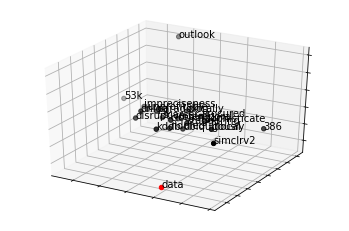

In [76]:
word = "data"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X_ = nlp[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X_ = pca.fit_transform(X_)
## create dtf
dtf_ = pd.DataFrame(X_, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [77]:
## tokenize text
tokenizer_ = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer_.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer_.word_index
## create sequence
lst_text2seq= tokenizer_.texts_to_sequences(lst_corpus)
## padding sequence
X_train_feature_matrix = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [78]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(corpus[i].split())
print("from: ", corpus[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train_feature_matrix[i])
print("to: ", X_train_feature_matrix[i], "| len:", len(X_train_feature_matrix[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", corpus[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[corpus[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  present paper show distributional information particularly important considering concept availability implicit language learning condition based result different behavioural experiment argue implicit learnability semantic regularity depends degree relevant concept reflected language use simulation train vector space model either english chinese corpus feed resulting representation feed forward neural network task neural network find mapping word representation novel word using datasets four behavioural experiment used different semantic manipulation able obtain learning pattern similar obtained human | len: 72
to:  [  35   13   11 1142   32  883  150  967  252 1757  919   37    3  267
    9] | len: 15
check:  present  -- idx in vocabulary --> 35
vocabulary:  {'NaN': 1, 'model': 2, 'learning': 3, 'algorithm': 4, 'method': 5} ... (padding element, 0)


In [79]:
abstract_df_test = X_test['abstractText'].replace("\n", " ")
corpus = abstract_df_test.values

## create list of n-grams
lst_corpus = []
for string in corpus:
    string = stemming_and_lemmatization(string)
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer_.texts_to_sequences(lst_corpus)

## padding sequence
X_test_feature_matrix = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [80]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [81]:
word = "data"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 7 |idx
embeddings[idx]: (300,) |vector


In [82]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="sigmoid")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=True)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(1, activation='sigmoid')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 300)      7637400     input_2[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 300, 15)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 300, 15)      240         permute_1[0][0]                  
____________________________________________________________________________________________

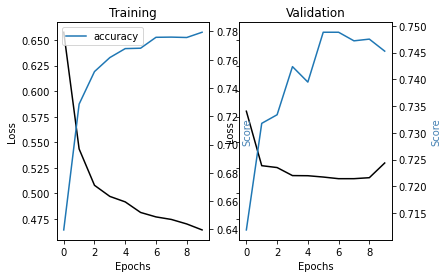

In [83]:
## train
training = model.fit(x=X_train_feature_matrix, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [84]:
## test
predicted_prob = model.predict(X_test_feature_matrix)
# predicted = model.predict(X_test_feature_matrix)
predicted = [1 if pred > 0.5 else 0 for pred in 
             predicted_prob]

Performance Metrics and Accuracy

Accuracy: 0.72
Detail:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      2691
           1       0.70      0.71      0.70      2420

    accuracy                           0.72      5111
   macro avg       0.72      0.72      0.72      5111
weighted avg       0.72      0.72      0.72      5111



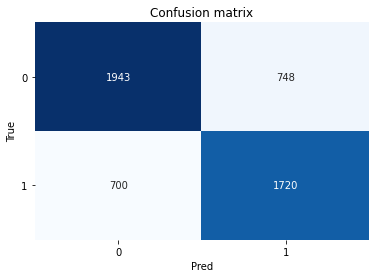

In [85]:
from sklearn import metrics
classes = np.unique(y_test)
accuracy = metrics.accuracy_score(y_test, predicted)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

plt.show()

True: 1 --> Pred: 1 | Prob: 0.92


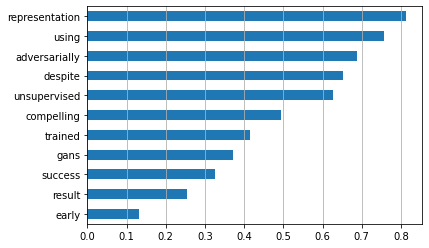

Text with highlighted words


In [86]:
## select observation
i = 1
txt_instance = X_test["abstractText"].iloc[i]

## check true value and predicted value
print("True:", y_test.tolist()[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

## show explanation
### 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    string = stemming_and_lemmatization(string)
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]    
    lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
X_instance = kprocessing.sequence.pad_sequences(
              tokenizer_.texts_to_sequences(corpus), maxlen=15, 
              padding="post", truncating="post")
### 2. get attention weights
layer = [layer for layer in model.layers if "attention" in 
         layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()
### 3. rescale weights, remove null vector, map word-weight
weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx 
           != 0]
dic_word_weigth = {word:weights[n] for n,word in 
                   enumerate(lst_corpus[0][:15]) if word in 
                   tokenizer_.word_index.keys()}
### 4. barplot
if len(dic_word_weigth) > 0:
   dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', 
                                columns=["score"])
   dtf.sort_values(by="score", 
           ascending=True).tail(20).plot(kind="barh", 
           legend=False).grid(axis='x')
   plt.show()
else:
   print("--- No word recognized ---")
### 5. produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)
### 6. visualize on notebook
print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text))